In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [135]:
import numpy as np
import pandas as pd
from datetime import date
from time import strptime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
# Create the inspector and connect it to the engine
Base = automap_base()
Base.prepare(autoload_with=engine)

In [41]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(f"The classes are: {classes}.")
Measurement = Base.classes.measurement
Station = Base.classes.station

# reflect the tables
inspector = inspect(engine)
tables = inspector.get_table_names()
print(f"The tables are: {classes}.")

The classes are: ['measurement', 'station'].
The tables are: ['measurement', 'station'].


In [42]:
# Save references to each table
for table in tables:
    print(f"{table} table:")
    print("-"*12)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

measurement table:
------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station table:
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [43]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [90]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(desc('date')).first()
print(f"The most recent measurement date is {most_recent.date} at station {most_recent.station}")

The most recent measurement date is 2017-08-23 at station USC00519397


In [132]:
end_date_parsed = strptime(most_recent.date, "%Y-%m-%d")
end_date_dt = date(end_date_parsed.tm_year, end_date_parsed.tm_mon, end_date_parsed.tm_mday)
start_date_dt = end_date_dt - relativedelta(months=12)
start_date_dt

datetime.date(2016, 8, 23)

In [131]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date_parsed = strptime(most_recent.date, "%Y-%m-%d")
end_date_dt = date(end_date_parsed.tm_year, end_date_parsed.tm_mon, end_date_parsed.tm_mday)
start_date_dt = end_date_dt - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date >= start_date_dt).all()

last_year_df = pd.DataFrame(query, columns=['date','prcp'])
last_year_df = last_year_df.sort_values('date')
last_year_df["date"] =  pd.to_datetime(last_year_df["date"], format="%Y-%m-%d")
last_year_indexed = last_year_df.set_index('date')

In [129]:
query

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [130]:
last_year_df

,date,prcp
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


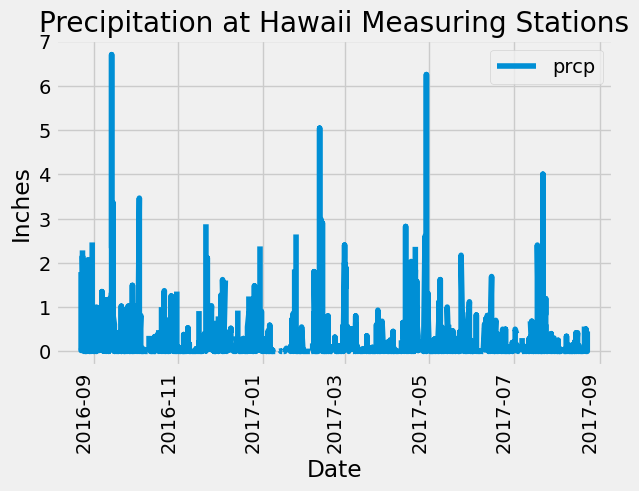

In [126]:
# using dataframe.plot
ax = last_year_indexed.plot(xlabel="Date",ylabel="Inches",title="Precipitation at Hawaii Measuring Stations",rot=90)
plt.show()

In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
unique_stations = session.query(Station.id, Station.station).distinct().count()
unique_stations

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station,func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = activity[0][0]
temp_stats = session.query(func.avg(Measurement.tobs).label('average'),func.max(Measurement.tobs).label('high'),func.min(Measurement.tobs).label('low')).\
                            filter(Measurement.station == most_active_station)

print(f"Lowest temperature: {temp_stats[0].low}")
print(f"Highest temperature: {temp_stats[0].high}")
print("Average temperature: " + "{:.2f}".format(temp_stats[0].average))

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66


In [53]:
# Using the most active station id
# Calculate the date one year from the last date in data set.

# get the most recent date of data collection for this station and subtract a year
most_recent = session.query(Measurement).order_by(desc('date')).\
        filter(Measurement.station == most_active_station).first()
end_date = most_recent.date
end_date_strings = end_date.split("-")
year = int(end_date_strings[0])
month = int(end_date_strings[1])
day = int(end_date_strings[2])
start_date = dt.date(year, month, day) - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
query = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= start_date).all()

last_year_df = pd.DataFrame(query, columns=['tobs'])

In [138]:
start_date

datetime.date(2016, 8, 18)

In [136]:
end_date = None
station = None

filters = [Measurement.date >= start_date]
if end_date != None:
    filters.append(Measurement.date <= end_date)
if station != None:
    filters.append(Measurement.station == station)
filters

In [137]:
temp_stats = session.query(func.avg(Measurement.tobs).label('average'),func.max(Measurement.tobs).label('high'),func.min(Measurement.tobs).label('low')).\
                            filter(*filters)

print(f"Lowest temperature: {temp_stats[0].low}")
print(f"Highest temperature: {temp_stats[0].high}")
print("Average temperature: " + "{:.2f}".format(temp_stats[0].average))

Lowest temperature: 58.0
Highest temperature: 87.0
Average temperature: 74.64


In [86]:
last_year_df

,date,station,tobs
0,2016-08-18,USC00519397,80.0
1,2016-08-19,USC00519397,77.0
2,2016-08-20,USC00519397,80.0
3,2016-08-21,USC00519397,76.0
4,2016-08-22,USC00519397,77.0
...,...,...,...
361,2017-08-19,USC00519397,79.0
362,2017-08-20,USC00519397,81.0
363,2017-08-21,USC00519397,81.0
364,2017-08-22,USC00519397,82.0


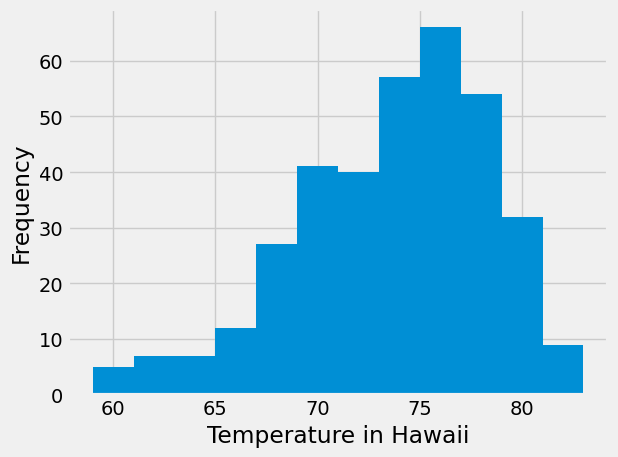

In [73]:
# plot the results as a histogram
fig, ax = plt.subplots(tight_layout=True)
ax.hist(last_year_df['tobs'],bins=12)
ax.set_xlabel("Temperature in Hawaii")
ax.set_ylabel("Frequency")
plt.show()

# Close Session

In [74]:
# Close Session
session.close()